In [ ]:
# ===============================
# ✅ 必要套件安裝 (請在終端機執行)
# ===============================
# pip install transformers datasets scikit-learn pandas torch torchvision torchaudio matplotlib seaborn openpyxl

import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    TextClassificationPipeline
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.font_manager as fm # For font checking/setting

# ===============================
# ✅ 路徑設定 (請根據你的本機資料夾結構修改)
# ===============================
DATA_DIR = "./data/" # 存放 CSV 檔案的資料夾
OUTPUT_DIR = "./output/" # 存放模型、結果、圖片的資料夾

# 確保輸出資料夾存在
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "bert_results"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "bert_logs"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "bert_model_chinese"), exist_ok=True)

# CSV 檔案路徑
FILE_DF1 = os.path.join(DATA_DIR, 'finfo_posts_產險_壽險_投資型.csv')
FILE_DF2 = os.path.join(DATA_DIR, 'mobile01_處理後.csv')
FILE_DF3 = os.path.join(DATA_DIR, 'ptt_語料_處理後.csv')

# 輸出檔案路徑
MODEL_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "bert_results")
LOGGING_DIR = os.path.join(OUTPUT_DIR, "bert_logs")
SAVED_MODEL_DIR = os.path.join(OUTPUT_DIR, "bert_model_chinese")
PREDICTION_CSV_PATH = os.path.join(OUTPUT_DIR, "prediction_result.csv")
PLOT_PATH = os.path.join(OUTPUT_DIR, "prediction_probability_distribution.png")


# ===============================
# ✅ 設定：快速訓練模式開關
# ===============================
QUICK_MODE = True  # True ➜ 抽樣快速訓練，False ➜ 全資料

# ===============================
# ✅ 載入資料（含欄位清理）
# ===============================
print("🔄 開始載入與處理資料...")
try:
    df1 = pd.read_csv("DATA_DIR/finfo_posts_產險_壽險_投資型.csv")
    df2 = pd.read_csv("DATA_DIR/mobile01_處理後.csv")
    df3 = pd.read_csv("DATA_DIR/ptt_語料_處理後.csv")
except FileNotFoundError as e:
    print(f"❌ 錯誤：找不到資料檔案！請確認路徑 '{DATA_DIR}' 下有指定的 CSV 檔案。")
    print(f"詳細錯誤：{e}")
    exit() # 找不到檔案直接結束程式

for df in [df1, df2, df3]:
    df.columns = df.columns.str.strip()

def extract_text(row):
    text = ''
    # 優先使用 '發文內容'/'留言內容' 或 'content'
    if 'content' in row and pd.notna(row['content']):
         text += str(row['content']) + ' '
    elif '發文內容' in row and pd.notna(row['發文內容']):
        text += str(row['發文內容']) + ' '
        # Finfos 可能同時有發文和留言，都加進去
        if '留言內容' in row and pd.notna(row['留言內容']):
           text += str(row['留言內容'])

    # 如果上面都沒有，嘗試其他可能的欄位（根據實際資料調整）
    # elif '其他欄位' in row and pd.notna(row['其他欄位']):
    #     text += str(row['其他欄位'])

    return text.strip()

def prepare_labeled_df(df):
    df['text'] = df.apply(extract_text, axis=1)
    # 確保 '詐騙關鍵詞次數' 欄位存在且為數值，若不存在或非數值則預設為0
    if '詐騙關鍵詞次數' not in df.columns:
        print(f"⚠️ 警告：資料集中缺少 '詐騙關鍵詞次數' 欄位，將假設所有 label 為 0。")
        df['label'] = 0
    else:
        # 嘗試轉換為數值，無法轉換的設為 0
        df['詐騙關鍵詞次數'] = pd.to_numeric(df['詐騙關鍵詞次數'], errors='coerce').fillna(0)
        df['label'] = df['詐騙關鍵詞次數'].apply(lambda x: 1 if x > 0 else 0)
    return df[['text', 'label']]

# 處理 df2 和 df3 作為訓練資料
df_train_list = []
print("處理 df2 (Mobile01)...")
df_train_list.append(prepare_labeled_df(df2))
print("處理 df3 (PTT)...")
df_train_list.append(prepare_labeled_df(df3))
df_train = pd.concat(df_train_list, ignore_index=True)

# 處理 df1 作為預測資料
print("處理 df1 (Finfo)...")
df_unlabeled = df1.copy()
df_unlabeled['text'] = df_unlabeled.apply(extract_text, axis=1)

# 移除 text 為空字串的資料 (避免 Tokenizer 出錯)
df_train = df_train[df_train['text'].str.strip() != '']
df_unlabeled = df_unlabeled[df_unlabeled['text'].str.strip() != '']

# 🔹 快速模式：抽樣訓練資料
if QUICK_MODE:
    n_samples = min(10000, len(df_train)) # 防止總資料少於一萬筆而出錯
    if len(df_train) > n_samples:
        df_train = df_train.sample(n=n_samples, random_state=42)
        print(f"⚡ 快速模式啟用：抽樣 {n_samples} 筆資料訓練")
    else:
        print(f"⚡ 快速模式啟用：使用全部 {len(df_train)} 筆資料訓練 (總數少於或等於抽樣數)")


print(f"✅ 清理與準備完成：")
print(f"   訓練樣本數：{len(df_train)}")
print(f"   預測樣本數：{len(df_unlabeled)}")
print(f"   訓練資料標籤分佈:\n{df_train['label'].value_counts(normalize=True)}")


# ===============================
# ✅ tokenizer + 切分 Dataset
# ===============================
print("\n🔄 開始 Tokenization 與資料集準備...")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

def tokenize_function(example):
    # 增加 max_length 以捕捉更長文本，但注意 VRAM 消耗
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

try:
    raw_dataset = Dataset.from_pandas(df_train)
    tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, remove_columns=['text']) # 移除原始 text 節省記憶體
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="labels") # 使用分層抽樣
    train_dataset = split_dataset["train"]
    eval_dataset = split_dataset["test"]

    print(f"✅ Tokenization 完成：")
    print(f"   Train size: {len(train_dataset)}")
    print(f"   Eval size: {len(eval_dataset)}")
except Exception as e:
    print(f"❌ Tokenization 或資料集轉換失敗：{e}")
    exit()

# ===============================
# ✅ 模型 + 訓練設定 + EarlyStopping
# ===============================
print("\n🔄 開始設定模型與訓練參數...")
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)

# --- 訓練參數 ---
# !! 注意 !! 如果遇到 CUDA Out of Memory (OOM) 錯誤，請優先降低 per_device_train_batch_size
# GTX 1060 6GB 在 max_length=256 時，batch_size 可能需要設為 4 或 2
# 如果 max_length=128，batch_size=8 或許可以，但仍需嘗試
TRAIN_BATCH_SIZE = 4 # 降低 batch size 以適應 GTX 1060 (可嘗試 8, 4, 2)
EVAL_BATCH_SIZE = 8 # 評估時 batch size 通常可以稍大 (可嘗試 16, 8)
NUM_EPOCHS = 3 if QUICK_MODE else 10

training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir=LOGGING_DIR,
    logging_strategy="epoch",
    metric_for_best_model="eval_f1", # 改用 F1 作為主要評估指標可能更適合不平衡資料
    save_total_limit=1,          # 只保留最好的模型
    report_to="none",            # 關掉 wandb 等外部報告
    fp16=torch.cuda.is_available(), # ✅ 自動啟用混合精度 (如果 CUDA 可用)
    gradient_accumulation_steps=2, # 梯度累積，等效 batch size = TRAIN_BATCH_SIZE * 2，可稍微彌補小 batch size
    learning_rate=3e-5,          # 常用的學習率
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)] # 加入 threshold 避免微小改善也繼續等
)

print(f"✅ 設定完成，準備開始訓練...")
print(f"   使用 GPU: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   CUDA 裝置: {torch.cuda.get_device_name(0)}")
print(f"   訓練 Epochs: {NUM_EPOCHS}")
print(f"   訓練 Batch Size (Per Device): {TRAIN_BATCH_SIZE}")
print(f"   梯度累積步數: {training_args.gradient_accumulation_steps}")
print(f"   等效 Batch Size: {TRAIN_BATCH_SIZE * training_args.gradient_accumulation_steps}")
print(f"   評估 Batch Size (Per Device): {EVAL_BATCH_SIZE}")
print(f"   混合精度 (FP16): {training_args.fp16}")

# ===============================
# ✅ 模型訓練
# ===============================
print("\n🏋️‍♂️ 開始訓練模型...")
try:
    trainer.train()
    print("✅ 訓練完成！")
except RuntimeError as e:
    if "CUDA out of memory" in str(e):
        print("\n❌ 錯誤：CUDA Out of Memory！")
        print("🧠 建議：請嘗試降低 TrainingArguments 中的 'per_device_train_batch_size'。")
        print(f"   目前的設定是 {TRAIN_BATCH_SIZE}，可以試試 4 或 2。")
        print(f"   或者減少 tokenize_function 中的 'max_length' (目前是 {tokenizer.model_max_length})。")
    else:
        print(f"\n❌ 訓練過程中發生錯誤：{e}")
    exit()
except Exception as e:
    print(f"\n❌ 訓練過程中發生未預期錯誤：{e}")
    exit()


# ===============================
# ✅ 儲存模型
# ===============================
print(f"\n💾 正在儲存最佳模型至：{SAVED_MODEL_DIR}")
trainer.save_model(SAVED_MODEL_DIR)
tokenizer.save_pretrained(SAVED_MODEL_DIR)
print("✅ 模型與 Tokenizer 儲存完成。")

# ===============================
# ✅ 預測流程 + 輸出 CSV
# ===============================
print("\n📊 開始使用訓練好的模型進行預測...")

# 重新載入最佳模型以確保使用的是儲存的版本
model = BertForSequenceClassification.from_pretrained(SAVED_MODEL_DIR)
tokenizer = BertTokenizerFast.from_pretrained(SAVED_MODEL_DIR)

# 設定 pipeline device
device_num = 0 if torch.cuda.is_available() else -1

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True, # 獲取所有類別分數
    device=device_num       # 使用 GPU (如果可用)
)

# 執行預測 (如果資料量大，這一步可能也需要一些時間)
# 使用 tolist() 避免傳遞 Series 物件可能造成的問題
texts_to_predict = df_unlabeled["text"].tolist()

# 分批預測以控制記憶體使用
batch_size = 32 # 可以根據你的 RAM 和 VRAM 調整
results = []
print(f"   預測總筆數: {len(texts_to_predict)}，批次大小: {batch_size}")
for i in range(0, len(texts_to_predict), batch_size):
    batch_texts = texts_to_predict[i:i + batch_size]
    batch_results = pipe(batch_texts)
    results.extend(batch_results)
    print(f"   已預測 {min(i + batch_size, len(texts_to_predict))}/{len(texts_to_predict)} 筆")


# 處理預測結果
# 假設 Label 'LABEL_1' 代表詐騙 (需根據 pipeline 實際輸出確認)
pred_labels = []
pred_probs = []
for res in results:
    score_label_1 = 0.0
    highest_score_label = 0
    highest_score = 0.0
    for item in res:
        if item['label'] == 'LABEL_1':
            score_label_1 = item['score']
        if item['score'] > highest_score:
            highest_score = item['score']
            # 從 'LABEL_X' 中取出數字 X
            highest_score_label = int(item['label'].split('_')[-1])

    pred_labels.append(highest_score_label)
    pred_probs.append(round(score_label_1, 4)) # 儲存 LABEL_1 的機率

df_unlabeled["predicted_label"] = pred_labels
df_unlabeled["predicted_prob_scam"] = pred_probs # 欄位名改為更清晰

# 選擇要輸出的欄位 (只保留必要欄位，避免檔案過大)
output_columns = ['text', 'predicted_label', 'predicted_prob_scam']
# 如果原始 df1 有 ID 或其他重要欄位，也可以加入
# if 'id_column' in df_unlabeled.columns:
#     output_columns.insert(0, 'id_column')

df_unlabeled[output_columns].to_csv(PREDICTION_CSV_PATH, index=False, encoding="utf-8-sig")

print(f"✅ 完成預測！結果儲存於：{PREDICTION_CSV_PATH}")


# ===============================
# ✅ (新增) 繪製預測機率分佈圖
# ===============================
print("\n🎨 正在繪製預測機率分佈圖...")

# --- 字體設定 (針對本機 Matplotlib) ---
# Windows: C:/Windows/Fonts/msjh.ttc (微軟正黑體)
# macOS: /System/Library/Fonts/STHeiti Medium.ttc (黑體-繁 中等)
# Linux: 可能需要先安裝字型 (如 Noto Sans CJK TC) 並找到 .ttf 或 .otf 檔
# 如果找不到字體或不確定，可以註解掉下面幾行，但中文可能顯示為方塊
try:
    # 嘗試設定中文字體 (請根據你的作業系統修改路徑或字體名稱)
    font_path = None
    if os.path.exists("C:/Windows/Fonts/msjh.ttc"):
        font_path = "C:/Windows/Fonts/msjh.ttc"
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    elif os.path.exists("/System/Library/Fonts/STHeiti Medium.ttc"):
         # macOS 可能可以直接設定字體名稱
         plt.rcParams['font.sans-serif'] = ['Heiti TC'] # 或 'PingFang TC'
    elif os.path.exists("/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"): # 範例 Linux 路徑
        font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    else:
        print("⚠️ 未找到指定的中文字體，圖表中的中文可能無法正常顯示。")

    plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題
except Exception as font_e:
    print(f"⚠️ 設定中文字體時發生錯誤: {font_e}. 中文可能無法正常顯示。")
# --- 字體設定結束 ---

plt.figure(figsize=(12, 7))
sns.histplot(data=df_unlabeled, x="predicted_prob_scam", kde=True, bins=50, color="skyblue") # 使用 50 個區間
plt.title("預測為詐騙 (Label=1) 的機率分佈", fontsize=16)
plt.xlabel("模型預測為詐騙的機率值", fontsize=12)
plt.ylabel("資料筆數", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 加上閾值線
threshold = 0.5
plt.axvline(x=threshold, color='r', linestyle='--', label=f'分類閾值 = {threshold}')

# 在圖上顯示一些統計數據
mean_prob = df_unlabeled["predicted_prob_scam"].mean()
median_prob = df_unlabeled["predicted_prob_scam"].median()
plt.axvline(x=mean_prob, color='g', linestyle=':', label=f'平均機率 = {mean_prob:.3f}')
plt.legend(fontsize=10)

plt.tight_layout() # 自動調整邊距

# 儲存圖片
plt.savefig(PLOT_PATH, dpi=300) # 提高解析度
# plt.show() # 如果希望在 VS Code 中彈出視窗顯示圖表，取消此行註解

print(f"✅ 機率分佈圖儲存於：{PLOT_PATH}")


# ===============================
# ✅ (新增) 簡單解釋
# ===============================
print("\n===== 📊 圖表與結果解釋 =====")
print(f"模型已對 {len(df_unlabeled)} 筆來自 '{os.path.basename(FILE_DF1)}' 的資料進行了預測。")
print(f"詳細預測結果（含原始文本、預測標籤、詐騙機率）儲存在：\n{PREDICTION_CSV_PATH}")
print(f"\n預測機率分佈圖儲存在：\n{PLOT_PATH}")
print("這張圖顯示了模型將每筆資料判斷為「詐騙」(Label=1) 的信心程度（機率值）的分佈情況。")
print("\n圖表觀察重點：")
print("1. 【形狀】機率分佈是否呈現『雙峰』？")
print("   - 若大量資料的機率集中在接近 0 和接近 1 的兩端，表示模型對大部分樣本的判斷比較『有信心』（明確判斷為非詐騙或詐騙）。")
print("   - 若機率集中在中間（如 0.5 附近），表示模型對很多樣本的判斷比較『模糊』或『不確定』。")
print("2. 【重心】機率主要集中在哪一邊？")
print(f"   - 平均機率 ({mean_prob:.3f}) 和中位數機率 ({median_prob:.3f}) 可以提供參考。")
print("   - 如果大部分機率值都偏低（接近 0），表示模型傾向於認為大部分文本『不是』詐騙。")
print("   - 如果大部分機率值都偏高（接近 1），表示模型傾向於認為大部分文本『是』詐騙。")
print("3. 【閾值附近】紅色虛線（預設 0.5）是常用的分類界線。")
print("   - 在這條線附近的樣本，是模型判斷結果『模棱兩可』的區域。改變閾值會影響最終哪些樣本被歸類為詐騙。")
print("   - 這些閾值附近的樣本可能最需要人工複查。")
print("\n👉 建議：打開 CSV 檔案，對照高機率、低機率以及機率在閾值附近的文本，檢查模型的判斷是否符合預期。")
print("==============================")

c:\Users\Robby1206\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 開始載入與處理資料...
處理 df2 (Mobile01)...
處理 df3 (PTT)...
處理 df1 (Finfo)...
⚡ 快速模式啟用：抽樣 10000 筆資料訓練
✅ 清理與準備完成：
   訓練樣本數：10000
   預測樣本數：5999
   訓練資料標籤分佈:
label
1    0.8173
0    0.1827
Name: proportion, dtype: float64

🔄 開始 Tokenization 與資料集準備...


Map: 100%|██████████| 10000/10000 [00:02<00:00, 3632.58 examples/s]


❌ Tokenization 或資料集轉換失敗：Stratifying by column is only supported for ClassLabel column, and column labels is Value.

🔄 開始設定模型與訓練參數...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

: 

In [1]:
pip install --upgrade transformers datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install datasets

   ---------------------------------------- 0.0/25.2 MB ? eta -:--:--
   --- ------------------------------------ 2.4/25.2 MB 12.1 MB/s eta 0:00:02
   -------- ------------------------------- 5.2/25.2 MB 12.6 MB/s eta 0:00:02
   ------------ --------------------------- 8.1/25.2 MB 13.4 MB/s eta 0:00:02
   ----------------- ---------------------- 10.7/25.2 MB 13.2 MB/s eta 0:00:02
   ----------------------- ---------------- 14.7/25.2 MB 14.7 MB/s eta 0:00:01
   ------------------------------- -------- 19.7/25.2 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------  24.6/25.2 MB 17.3 MB/s eta 0:00:01
   ---------------------------------------- 25.2/25.2 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


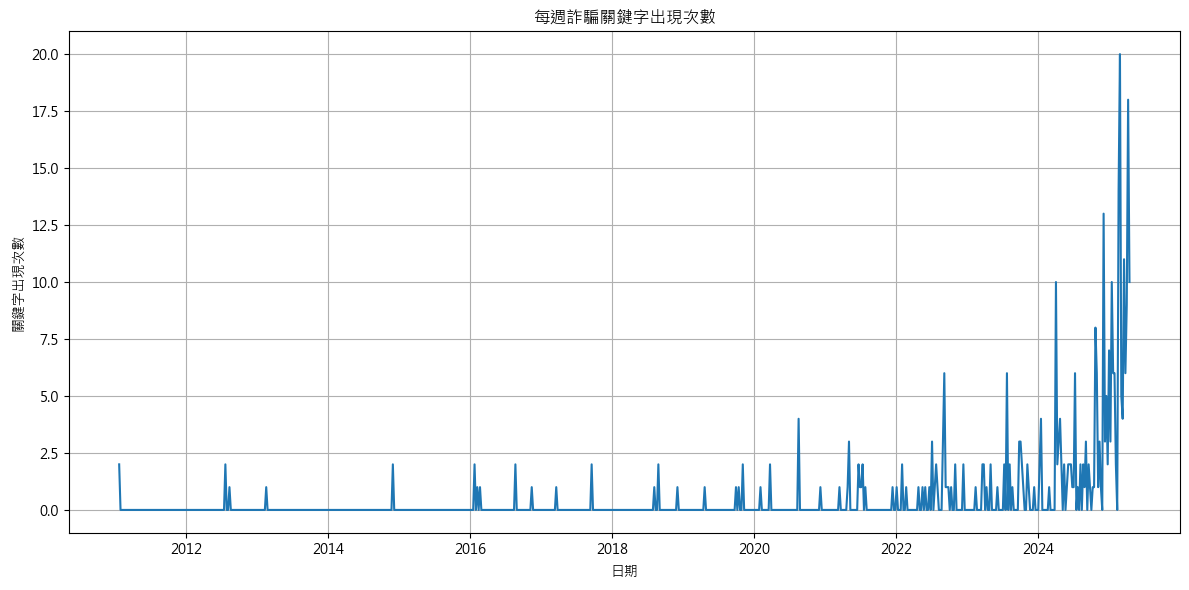

In [5]:
# 環境重置後需重新載入資料
import pandas as pd
# 環境重置導致先前上傳的詐騙關鍵字檔案遺失，我們將先重新上傳關鍵字內容

# 暫時用簡單詐騙關鍵字列表來模擬分析
scam_keywords = [
    "中獎", "緊急", "立刻", "拜託", "匯款", "ATM", "免費", "投資", "高薪", "限時", "趕緊", 
    "解除設定", "帳戶異常", "保證金", "代辦", "現金卡", "LINE 群組"
]

# 重新執行其他部分
ptt = pd.read_csv("DATA_DIR/ptt_語料_處理後.csv")
mobile = pd.read_csv("DATA_DIR/mobile01_處理後.csv")
finfo = pd.read_csv("DATA_DIR/finfo_posts_產險_壽險_投資型.csv")

for df in [ptt, mobile, finfo]:
    df.columns = df.columns.str.strip()

ptt["來源"] = "ptt"
mobile["來源"] = "mobile01"
finfo["來源"] = "finfo"
combined = pd.concat([ptt, mobile, finfo], ignore_index=True)

# 合併內容欄位
def extract_text(row):
    text = ''
    for col in ['發文內容', '留言內容', 'content']:
        if col in row and pd.notna(row[col]):
            text += str(row[col]) + ' '
    return text.strip()

combined["完整內容"] = combined.apply(extract_text, axis=1)

# 偵測詐騙關鍵字數量
def scam_count(text):
    return sum(1 for k in scam_keywords if k in text)

combined["詐騙關鍵字次數"] = combined["完整內容"].apply(scam_count)

# 日期欄推測與處理
possible_date_cols = ["日期", "時間", "發文時間", "資料抓取日", "publish_time"]
date_col = next((col for col in combined.columns if col in possible_date_cols), None)
combined[date_col] = pd.to_datetime(combined[date_col], errors='coerce')
combined = combined.dropna(subset=[date_col])
combined.set_index(date_col, inplace=True)

# 統計時間序列
weekly_scam = combined["詐騙關鍵字次數"].resample("W").sum()

# 繪圖
import matplotlib.pyplot as plt

# ✅ 設定中文字型
plt.rcParams['font.family'] = 'Microsoft JhengHei'


plt.figure(figsize=(12, 6))
plt.plot(weekly_scam.index, weekly_scam.values)
plt.title("每週詐騙關鍵字出現次數")
plt.xlabel("日期")
plt.ylabel("關鍵字出現次數")
plt.grid(True)
plt.tight_layout()
plt.show()
